Author: Judit Lozano Gondolbeu

### Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import warnings
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import TweedieRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

In [2]:
#with open('train.pickle', 'wb') as f:
    #pickle.dump([X_train, y_train, X_test, y_test], f)

In [3]:
#Cargamos las variables ya preparadas
with open('../data/train_smote.pickle', 'rb') as f:
    X_train_sm, y_train_sm, X_test, y_test = pickle.load(f)

In [4]:
X_train_sm.head()

,C_MNTH,C_WDAY,C_HOUR,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_TYPE,P_SAFE,V_YEAR,C_YEAR,P_AGE,P_SEX,PP_CAR
0,-1.129054,1.375704,0.651298,-0.824320,0.948994,-1.036199,0.531235,-0.363466,-0.251504,-0.225190,-0.118230,0.437172,-0.963827,0.816670,-1.450629
1,-1.129054,-0.417392,-0.779007,-0.824320,-0.246324,0.043446,-0.353054,-1.353824,-0.251504,-0.225190,0.097020,0.656122,-0.591176,-1.219878,0.839152
2,0.183556,-0.417392,-0.646253,1.246626,-0.246324,0.043446,-0.353054,-0.318034,-0.251504,0.074408,-0.154105,1.312973,-0.692808,-1.219878,0.839152
3,1.797639,-0.899118,-0.359585,1.246626,-0.246324,0.043446,-0.353054,0.851024,-0.711926,-0.369937,3.433395,0.437172,-0.828318,-1.219878,0.174065
4,-1.413490,-0.504111,-0.556747,-0.605457,0.909085,1.458426,-1.210185,-1.353824,-0.251504,-0.225190,-0.261729,-0.438630,-0.658931,-1.219878,0.839152


### Reducción de la dimensionalidad
Para evitar problemas de tiempo en la ejecución de los modelos debido al tamaño del dataset, procederemos a reducir la dimensionalidad de nuestro dataset:

### Regularización Ridge

In [5]:
sel_ridge = SelectFromModel(LogisticRegression(C=1, penalty='l2'), threshold = 0.05)
sel_ridge.fit(X_train_sm, y_train_sm)

SelectFromModel(estimator=LogisticRegression(C=1), threshold=0.05)

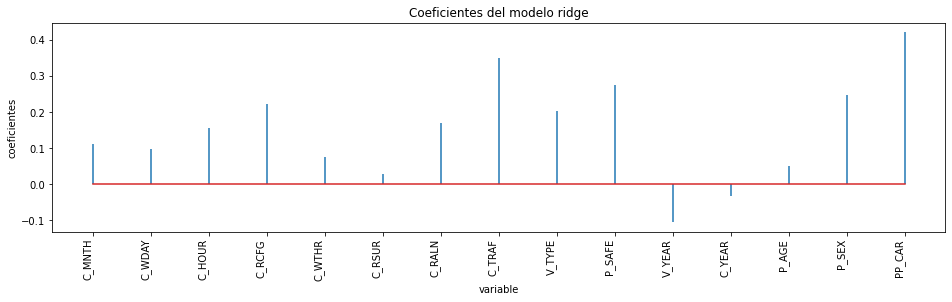

In [6]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train_sm.columns,
                         'coef': sel_ridge.estimator_.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(16, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo ridge');

In [7]:
sel_ridge.get_support()
selected_feat = X_train_sm.columns[sel_ridge.get_support()]
selected_feat

Index(['C_MNTH', 'C_WDAY', 'C_HOUR', 'C_RCFG', 'C_WTHR', 'C_RALN', 'C_TRAF',
       'V_TYPE', 'P_SAFE', 'V_YEAR', 'P_AGE', 'P_SEX', 'PP_CAR'],
      dtype='object')

In [8]:
print('total features: {}'.format((X_train_sm.shape[1])))
print('selected features: {}'.format(len(selected_feat)))

total features: 15
selected features: 13


Quitaremos dos variables que no tienen mucha importancia según el modelo ridge: C_RSUR y C_YEAR

### PCA

In [9]:
pca = PCA()#primero lo hago sin fijar el número de componentes para visualizar la varianza

pca.fit(X_train_sm[selected_feat])
X_train_pca = pca.transform(X_train_sm[selected_feat])
X_test_pca = pca.transform(X_test[selected_feat])

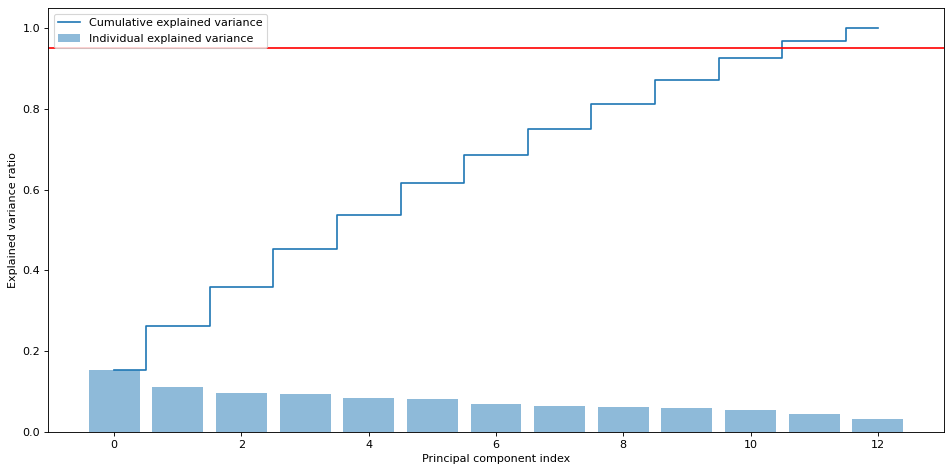

In [10]:
exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

threshold = 0.95
plt.figure(figsize=(12, 6), dpi=80)
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.axhline(y=threshold, color='r', linestyle='-')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Decidimos quedarnos con las 13 variables seleccionadas por el modelo Ridge y no reducimos más porque como muestra la gráfica del PCA, la varianza no se estabiliza en ningún punto en concreto como para cortar y quedarnos con un menor número de componentes.

In [11]:
X_train = X_train_sm[selected_feat]
X_test = X_test[selected_feat]
y_train = y_train_sm

#nos guardamos las variables después de aplicar la reduccion de Ridge
with open('../data/train_ridge.pickle', 'wb') as f:
    pickle.dump([X_train, y_train, X_test, y_test],f)